In [15]:
pip install cobra

In [16]:
!pip install gurobipy
import gurobipy as gp

### Import packages

In [17]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import cobra

print('Python version:', sys.version)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', matplotlib. __version__)
print('Pickle version:', pickle.format_version)
print('Cobrapy version:', cobra.__version__)

Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.4
Pandas version: 1.3.0
Matplotlib version: 3.3.3
Pickle version: 4.0
Cobrapy version: 0.20.0


In [18]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Create genome-scale model

In [19]:
from cobra.io import load_json_model, save_json_model, read_sbml_model, write_sbml_model
from cobra import Model, Reaction, Metabolite
from pandas import Series, DataFrame

model = load_json_model('iJN678.json')

In [20]:
#TCA cycle shunt reactions (Zhang and Bryant, 2011)

r_OXGDC = Reaction('OXGDC')
r_OXGDC.name = '2-oxoglutarate decarboxylase'
r_OXGDC.subsystem = 'Citrate cycle (TCA cycle)'
r_OXGDC.gene_reaction_rule = 'sll1981'
r_OXGDC.lower_bound = 0
r_OXGDC.upper_bound = 1000

r_OXGDC.add_metabolites({
                            model.metabolites.get_by_id("akg_c"): -1,
                            model.metabolites.get_by_id("h_c"): -1,
                            model.metabolites.get_by_id("co2_c"): 1,
                            model.metabolites.get_by_id("sucsal_c"): 1,
                           })

model.add_reactions([r_OXGDC])

#Light-independent serine biosynthesis pathway (Klemke et al., 2015)

r_PSTA = Reaction('PSTA')
r_PSTA.name = 'Phosphoserine transaminase'
r_PSTA.subsystem = 'Glycine and serine metabolism'
r_PSTA.gene_reaction_rule = 'sll1559'
r_PSTA.lower_bound = 0
r_PSTA.upper_bound = 1000

m_pser__L_c = Metabolite(id='pser__L_c', name='O-Phospho-L-serine', compartment='c', formula='C3H6NO6P')

r_PSTA.add_metabolites({model.metabolites.get_by_id("3php_c"): -1,
                        model.metabolites.get_by_id("glu__L_c"): -1,
                        model.metabolites.get_by_id("akg_c"): 1,
                        m_pser__L_c: 1, #
                        })

model.add_reactions([r_PSTA])

r_PSP = Reaction('PSP')
r_PSP.name = 'Phosphoserine phosphatase'
r_PSP.subsystem = 'Glycine and serine metabolism'
r_PSP.gene_reaction_rule = 'slr1124'
r_PSP.lower_bound = 0
r_PSP.upper_bound = 1000

r_PSP.add_metabolites({
                            model.metabolites.get_by_id("pser__L_c"): -1,
                            model.metabolites.get_by_id("h2o_c"): -1,
                            model.metabolites.get_by_id("h_c"): 2,
                            model.metabolites.get_by_id("pi_c"): 1,
                            model.metabolites.get_by_id("ser__L_c"): 1,
                            })

model.add_reactions([r_PSP])

#Phosphoketolase pathways (Xiong et al., 2015), (Bachhar et al., 2020)

r_PKETF = Reaction('PKETF')
r_PKETF.name = 'Phosphoketolase (fructose-6-phosphate utilizing)'
r_PKETF.subsystem = 'Pentose phosphate pathway'
r_PKETF.gene_reaction_rule = 'slr0453'
r_PKETF.lower_bound = 0
r_PKETF.upper_bound = 1000

r_PKETF.add_metabolites({model.metabolites.get_by_id("f6p_c"): -1,
                       model.metabolites.get_by_id("pi_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       model.metabolites.get_by_id("actp_c"): 1,
                       model.metabolites.get_by_id("e4p_c"): 1,
                       })

model.add_reactions([r_PKETF])

r_PKETX = Reaction('PKETX')
r_PKETX.name = 'Phosphoketolase (xylulose-5-phosphate utilizing)'
r_PKETX.subsystem = 'Pentose phosphate pathway'
r_PKETX.gene_reaction_rule = 'slr0453'
r_PKETX.lower_bound = 0
r_PKETX.upper_bound = 1000

r_PKETX.add_metabolites({model.metabolites.get_by_id("xu5p__D_c"): -1,
                       model.metabolites.get_by_id("pi_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       model.metabolites.get_by_id("actp_c"): 1,
                       model.metabolites.get_by_id("g3p_c"): 1,
                       })

model.add_reactions([r_PKETX])

#Entner–Doudoroff pathway (Chen et al., 2016)

r_GDH = Reaction('GDH')
r_GDH.name = 'Glucose dehydrogenase'
r_GDH.subsystem = 'Pentose phosphate pathway'
r_GDH.gene_reaction_rule = 'sll1709'
r_GDH.lower_bound = 0
r_GDH.upper_bound = 1000

m_glcn_c = Metabolite(id='glcn_c', name='D-Gluconate', compartment='c', formula='C6H11O7') #, charge='-1'

r_GDH.add_metabolites({model.metabolites.get_by_id("glc__bD_c"): -1,
                       model.metabolites.get_by_id("nadp_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): -1,
                       model.metabolites.get_by_id("nadph_c"): 1,
                       model.metabolites.get_by_id("h_c"): 2,
                       m_glcn_c: 1, #
                       })

model.add_reactions([r_GDH])

r_GNK = Reaction('GNK')
r_GNK.name = 'Gluconokinase'
r_GNK.subsystem = 'Pentose phosphate pathway'
r_GNK.gene_reaction_rule = 'sll0593'
r_GNK.lower_bound = 0
r_GNK.upper_bound = 1000

r_GNK.add_metabolites({model.metabolites.get_by_id("atp_c"): -1,
                       model.metabolites.get_by_id("glcn_c"): -1,
                       model.metabolites.get_by_id("6pgc_c"): 1,
                       model.metabolites.get_by_id("adp_c"): 1,
                       model.metabolites.get_by_id("h_c"): 1,
                       })

model.add_reactions([r_GNK])

r_EDD = Reaction('EDD')
r_EDD.name = '6-phosphogluconate dehydratase'
r_EDD.subsystem = 'Pentose phosphate pathway'
r_EDD.gene_reaction_rule = 'slr0452'
r_EDD.lower_bound = 0
r_EDD.upper_bound = 1000

m_2ddg6p_c = Metabolite(id='2ddg6p_c', name='2-Dehydro-3-deoxy-D-gluconate 6-phosphate', compartment='c', formula='C6H8O9P') #, charge='-3'

r_EDD.add_metabolites({model.metabolites.get_by_id("6pgc_c"): -1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       m_2ddg6p_c: 1,
                       })

model.add_reactions([r_EDD])

r_EDA = Reaction('EDA')
r_EDA.name = '2-dehydro-3-deoxy-phosphogluconate aldolase'
r_EDA.subsystem = 'Pentose phosphate pathway'
r_EDA.gene_reaction_rule = 'sll0107'
r_EDA.lower_bound = 0
r_EDA.upper_bound = 1000

r_EDA.add_metabolites({model.metabolites.get_by_id("2ddg6p_c"): -1,
                       model.metabolites.get_by_id("g3p_c"): 1,
                       model.metabolites.get_by_id("pyr_c"): 1,
                        })

model.add_reactions([r_EDA])

#Modification to tyrosine biosynthesis (Bonner et al., 2004)

r_PAT1 = Reaction('PAT1')
r_PAT1.name = 'Prephenate transaminase (aspartate donor)'
r_PAT1.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PAT1.gene_reaction_rule = ''
r_PAT1.lower_bound = 0
r_PAT1.upper_bound = 1000

m_Largn_c = Metabolite(id='Largn_c', name='L-Arogenate', compartment='c', formula='C10H13NO5')

r_PAT1.add_metabolites({model.metabolites.get_by_id("pphn_c"): -1,
                       model.metabolites.get_by_id("asp__L_c"): -1,
                       model.metabolites.get_by_id("h_c"): -1,
                       model.metabolites.get_by_id("oaa_c"): 1,
                       m_Largn_c: 1,
                        })

model.add_reactions([r_PAT1])

r_PAT2 = Reaction('PAT2')
r_PAT2.name = 'Prephenate transaminase (glutamate donor)'
r_PAT2.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PAT2.gene_reaction_rule = ''
r_PAT2.lower_bound = 0
r_PAT2.upper_bound = 1000

r_PAT2.add_metabolites({model.metabolites.get_by_id("pphn_c"): -1,
                       model.metabolites.get_by_id("glu__L_c"): -1,
                       model.metabolites.get_by_id("h_c"): -1,
                       model.metabolites.get_by_id("Largn_c"): 1,
                       model.metabolites.get_by_id("akg_c"): 1,
                        })

model.add_reactions([r_PAT2])

r_PHEA = Reaction('PHEA')
r_PHEA.name = 'Prephenate dehydratase'
r_PHEA.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PHEA.gene_reaction_rule = 'sll1662'
r_PHEA.lower_bound = 0
r_PHEA.upper_bound = 1000

r_PHEA.add_metabolites({model.metabolites.get_by_id("Largn_c"): -1,
                       model.metabolites.get_by_id("phe__L_c"): 1,
                       model.metabolites.get_by_id("h2o_c"): 1,
                       model.metabolites.get_by_id("co2_c"): 1,
                        })

model.add_reactions([r_PHEA])

r_PHEA = Reaction('TYRA')
r_PHEA.name = 'Arogenate dehydrogenase'
r_PHEA.subsystem = 'Phenylalanine tyrosine and tryptophan biosynthesis'
r_PHEA.gene_reaction_rule = 'slr2081'
r_PHEA.lower_bound = 0
r_PHEA.upper_bound = 1000

r_PHEA.add_metabolites({model.metabolites.get_by_id("Largn_c"): -1,
                       model.metabolites.get_by_id("nadp_c"): -1,
                       model.metabolites.get_by_id("tyr__L_c"): 1,
                       model.metabolites.get_by_id("h_c"): 1,
                       model.metabolites.get_by_id("nadph_c"): 1,
                       model.metabolites.get_by_id("co2_c"): 1,
                        })

model.add_reactions([r_PHEA])

#Modification to Glycine Cleavage System (Joshi et al., 2017)

model.reactions.GLYCL_2.bounds = (0, 0)
model.reactions.GLYCL.bounds = (0, 0)

r_GLYCLa = Reaction('GLYCLa')
r_GLYCLa.name = 'Glycine Cleavage System'
r_GLYCLa.subsystem = 'Photorespiration'
r_GLYCLa.gene_reaction_rule = '(sll0171 or slr0879 or slr0293)'
r_GLYCLa.lower_bound = -1000
r_GLYCLa.upper_bound = 1000

m_samprot_c = Metabolite(id='samprot_c', name='S-Aminomethyldihydrolipoylprotein', compartment='c', formula='C6H9N3O')
m_lprot_c = Metabolite(id='lprot_c', name='Lipoylprotein', compartment='c', formula='C6H9N3O')

r_GLYCLa.add_metabolites({model.metabolites.get_by_id("gly_c"): -1,
                       m_lprot_c: -1,
                       model.metabolites.get_by_id("co2_c"): 1,
                       m_samprot_c: 1,
                        })

model.add_reactions([r_GLYCLa])

r_GLYCLb = Reaction('GLYCLb')
r_GLYCLb.name = 'Glycine Cleavage System'
r_GLYCLb.subsystem = 'Photorespiration'
r_GLYCLb.gene_reaction_rule = '(sll0171 or slr0879 or slr0293)'
r_GLYCLb.lower_bound = -1000
r_GLYCLb.upper_bound = 1000

m_dhlprot_c = Metabolite(id='dhlprot_c', name='dihydrolipolprotein', compartment='c', formula='C6H9N3O')

r_GLYCLb.add_metabolites({model.metabolites.get_by_id("thf_c"): -1,
                       model.metabolites.get_by_id("samprot_c"): -1,
                       model.metabolites.get_by_id("mlthf_c"): 1,
                       model.metabolites.get_by_id("nh4_c"): 1,
                       m_dhlprot_c: 1,
                       })

model.add_reactions([r_GLYCLb])

r_GLYCLc = Reaction('GLYCLc')
r_GLYCLc.name = 'Glycine Cleavage System'
r_GLYCLc.subsystem = 'Photorespiration'
r_GLYCLc.gene_reaction_rule = '(sll0171 or slr0879 or slr0293)'
r_GLYCLc.lower_bound = -1000
r_GLYCLc.upper_bound = 1000

m_dhlprot_c = Metabolite(id='dhlprot_c', name='dihydrolipolprotein', compartment='c', formula='C6H9N3O')

r_GLYCLc.add_metabolites({model.metabolites.get_by_id("nad_c"): -1,
                       model.metabolites.get_by_id("dhlprot_c"): -1,
                       model.metabolites.get_by_id("h_c"): 1,
                       model.metabolites.get_by_id("nadh_c"): 1,
                       model.metabolites.get_by_id("lprot_c"): 1,
                        })

model.add_reactions([r_GLYCLc])

#Modification to electron-transport chain reactions (Lea-Smith et al., 2015).

model.reactions.NDH1_1p.bounds = (0, 0)
model.reactions.NDH1_2p.bounds = (0, 0)
model.reactions.CBFCpp.bounds = (0, 0)
model.reactions.CBFC2pp.bounds = (0, 0)
model.reactions.CYO1b2pp_syn.bounds = (0, 0)
model.reactions.CYO1bpp_syn.bounds = (0, 0)
model.reactions.CYO1b2_syn.bounds = (0, 0)

r_NDH2_2p = Reaction('NDH2_1p')
r_NDH2_2p.name = 'NADH dehydrogenase 2'
r_NDH2_2p.subsystem = 'Oxidative phosphorylation'
r_NDH2_2p.gene_reaction_rule = 'slr1743'
r_NDH2_2p.lower_bound = 0
r_NDH2_2p.upper_bound = 1000

r_NDH2_2p.add_metabolites({model.metabolites.get_by_id("h_c"): -1,
                       model.metabolites.get_by_id("nadh_c"): -1,
                       model.metabolites.get_by_id("pq_p"): -1,
                       model.metabolites.get_by_id("nad_c"): 1,
                       model.metabolites.get_by_id("pqh2_p"): 1,
                       })

model.add_reactions([r_NDH2_2p])

r_ARTO = Reaction('ARTO')
r_ARTO.name = 'Alternative respiratory terminal oxidase'
r_ARTO.subsystem = 'Photosynthesis'
r_ARTO.gene_reaction_rule = '(slr2082 or slr2083 or sll0813)'
r_ARTO.lower_bound = 0
r_ARTO.upper_bound = 1000

r_ARTO.add_metabolites({model.metabolites.get_by_id("h_c"): -2,
                       model.metabolites.get_by_id("pqh2_p"): -1,
                       model.metabolites.get_by_id("o2_p"): -0.5,
                       model.metabolites.get_by_id("pq_p"): 1,
                       model.metabolites.get_by_id("h2o_p"): 1,
                       })

model.add_reactions([r_ARTO])

r_Flv2_Flv4 = Reaction('Flv2_4')
r_Flv2_Flv4.name = 'Flavodiiron 2/4'
r_Flv2_Flv4.subsystem = 'Photosynthesis'
r_Flv2_Flv4.gene_reaction_rule = '(sll0219 or sll0217)'
r_Flv2_Flv4.lower_bound = 0
r_Flv2_Flv4.upper_bound = 1000

r_Flv2_Flv4.add_metabolites({model.metabolites.get_by_id("h_c"): -2,
                                    model.metabolites.get_by_id("pqh2_u"): -1,
                                    model.metabolites.get_by_id("o2_u"): -0.5,
                                    model.metabolites.get_by_id("pq_u"): 1,
                                    model.metabolites.get_by_id("h2o_u"): 1,
                                    })

model.add_reactions([r_Flv2_Flv4])

#Modification to transhydrogenase PntAB (Kämäräinen, et al., 2016).

#model.reactions.NADTRHD.bounds = (-1000, 10000)

#Modification to Leucine transaminas (Joshi et al., 2017).
model.reactions.LEUTAi.bounds = (0, 0)

#ATP maintenance requirement

r_NGAM = Reaction('ATPM')
r_NGAM.name = 'ATP maintenance requirement'
r_NGAM.subsystem = 'Biomass and maintenance functions'
r_NGAM.gene_reaction_rule = ''
r_NGAM.lower_bound = 0
r_NGAM.upper_bound = 1000

r_NGAM.add_metabolites({model.metabolites.get_by_id("atp_c"): -1,
                                    model.metabolites.get_by_id("h2o_c"): -1,
                                    model.metabolites.get_by_id("adp_c"): 1,
                                    model.metabolites.get_by_id("h_c"): 1,
                                    model.metabolites.get_by_id("pi_c"): 1,
                        })

model.add_reactions([r_NGAM])

In [22]:
# Biosynthesis reactions

r_isb1 = Reaction('KICD')
r_isb1.name = 'alpha-ketoisocaproate dioxygenase/decarboxylase'
r_isb1.subsystem = 'Valine leucine and isoleucine biosynthesis'
r_isb1.gene_reaction_rule = 'RnKICD'
r_isb1.lower_bound = 0
r_isb1.upper_bound = 1000
                             
m_3hivac_c = Metabolite('m_3hivac_c', name='3-hydroxyisovaleric acid (HMB)', compartment='c', formula='C5H9O3')
r_isb1.add_metabolites({
                                    model.metabolites.get_by_id("4mop_c"): -1,
                                    model.metabolites.get_by_id("o2_c"): -1,
                                    model.metabolites.get_by_id("co2_c"): 1,
                                    m_3hivac_c: 1,
                                    })

model.add_reactions([r_isb1])

r_isb2 = Reaction('M3K') # C5H9O3 + ATP → C5H8O3P → C4H8 + CO2 + Pi
r_isb2.name = 'mevalonate-3-kinase'
r_isb2.subsystem = 'Valine leucine and isoleucine biosynthesis'
r_isb2.gene_reaction_rule = 'PtM3K'
r_isb2.lower_bound = 0
r_isb2.upper_bound = 1000

m_3piv_c = Metabolite('m_3piv_c', name='3-phosphoisovalerate', compartment='c', formula='C5H8O3P')
r_isb2.add_metabolites({
                                    model.metabolites.get_by_id("m_3hivac_c"): -1,
                                    model.metabolites.get_by_id("atp_c"): -1,
                                    model.metabolites.get_by_id("adp_c"): 1,
                                    m_3piv_c: 1,
                                    })

model.add_reactions([r_isb2])

r_isb3 = Reaction('Isobutene_spontaneous')
r_isb3.name = 'Isobutene spontaneous'
r_isb3.subsystem = 'Valine leucine and isoleucine biosynthesis'
r_isb3.gene_reaction_rule = ''
r_isb3.lower_bound = 0
r_isb3.upper_bound = 1000

m_isobutene_c = Metabolite('isb_c', name='isobutene', compartment='c', formula='C4H8')
r_isb3.add_metabolites({
                                    model.metabolites.get_by_id("m_3piv_c"): -1,
                                    model.metabolites.get_by_id("co2_c"): 1,
                                    model.metabolites.get_by_id("pi_c"): 1,
                                    m_isobutene_c: 1,
                                    })

model.add_reactions([r_isb3])

# Transport reactions
r_isb4 = Reaction('ISBt')
r_isb4.name = 'Isobutene transport via diffusion (cytoplasm to extracellular))'
r_isb4.subsystem = 'Valine leucine and isoleucine biosynthesis'
r_isb4.gene_reaction_rule = ''
r_isb4.lower_bound = 0
r_isb4.upper_bound = 1000

m_isobutene_e = Metabolite(id='isb_e', name='isobutene', compartment='e', formula='C4H8')
r_isb4.add_metabolites({
                            model.metabolites.get_by_id("isb_c"): -1,
                            m_isobutene_e: 1,
                            })

model.add_reactions([r_isb4])

# Exchange reactions
r_isb5 = Reaction('EX_isb_e')
r_isb5.name = 'Isobutene exchange'
r_isb5.subsystem = 'Valine leucine and isoleucine biosynthesis'
r_isb5.gene_reaction_rule = ''
r_isb5.lower_bound = 0
r_isb5.upper_bound = 1000
r_isb5.add_metabolites({model.metabolites.get_by_id("isb_e") : -1})

model.add_reactions([r_isb5])

r_isb5

Reaction identifier,EX_isb_e
Name,Isobutene exchange
Memory address,0x018095878c40
Stoichiometry,isb_e --> isobutene -->
GPR,
Lower bound,0
Upper bound,1000


In [103]:
#save new GSM

#cobra.io.write_sbml_model(iJN678_AK_isobutene.xml')
#cobra.io.save_json_model(model, "iJN678_AK_isobutene.json")

### MEMOTE analysis

In [24]:
pip install memote

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pytest>=4.0 in c:\programdata\anaconda3\envs\cobrapy_ms\lib\site-packages (from memote) (4.6.11)


In [25]:
#import memote
#!memote report snapshot '/iJN678_2023_isobutene.xml' --filename '/iJN678_2023_isobutene.html'

### Set model constraints

In [26]:
#set model objective to autotrophic growth
model.objective = 'BIOMASS_Ec_SynAuto'
#set photoautotropic growth by constraining glucose exchange reatcion
model.reactions.EX_glc__D_e.bounds = (0, 1000)
#set photoautotropic growth by constraining HCO3 exchange reatcion.
model.reactions.EX_co2_e.bounds = (0, 1000)
model.reactions.EX_hco3_e.bounds = (-3.7, 1000)
#set photon flux to lab scale conditions.
model.reactions.EX_photon_e.bounds = (-45, -45)
#blocking transhydrogenase PntAB
model.reactions.NADTRHD.bounds = (0, 0)

In [27]:
from cobra.flux_analysis.loopless import add_loopless

add_loopless(model)

### Phenotype phase plane

<AxesSubplot:xlabel='Growth rate (1/h)', ylabel='Production rate (mmol/gDW/h)'>

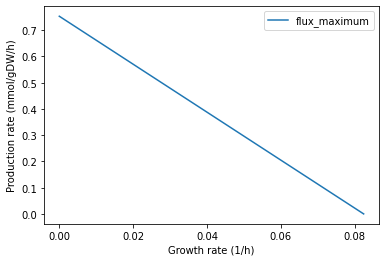

In [28]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope

ppp = production_envelope(model,
                    reactions=[model.reactions.BIOMASS_Ec_SynAuto],
                    objective=model.reactions.EX_isb_e)
ppp.plot(x='BIOMASS_Ec_SynAuto', y='flux_maximum', xlabel = 'Growth rate (1/h)', ylabel = 'Production rate (mmol/gDW/h)')

### Set growth and alkene production rate

In [29]:
pfba_solution = cobra.flux_analysis.pfba(model)
uMAX = pfba_solution.fluxes["BIOMASS_Ec_SynAuto"]
uMAX

0.08239866638336935

In [30]:
model.reactions.BIOMASS_Ec_SynAuto.lower_bound = 0.1 * uMAX
model.objective = model.reactions.EX_isb_e
pfba_solution = cobra.flux_analysis.pfba(model)
production = abs(pfba_solution.fluxes["EX_isb_e"])
production

0.6778161450876041

In [100]:
pip install escher

In [102]:
import escher
from escher import Builder

pfba_solution_escher = cobra.flux_analysis.pfba(model)

builder = Builder(
    map_json = '#AMP_SOG_SER_PSP_map_titles.json',
    model_json='iJN678_2023_isobutene_auto.json',
    reaction_data=abs(pfba_solution_escher.fluxes)
)

builder.save_html('AMP_SOG_SER_PSP_iJN678_2023_isobutene_auto.html')

### Productivity and yield

In [31]:
with model as model:
    model.objective = model.reactions.EX_isb_e
    pfba_solution = cobra.flux_analysis.pfba(model)
    production = abs(pfba_solution.fluxes["EX_isb_e"])
    print("Maximum productivity =", production, "[mmol p/gDW/h]")
       
    #Calculate a molar yield (mol product / mol carbon source)
    maximum_theoretical_yield = production / abs(pfba_solution.fluxes["EX_hco3_e"])
    print("Maximum theoretical molar yield =", maximum_theoretical_yield, "[mmol p / mmol s]")
          
    #Calculate a mass yield instead of molar yield (g (product) / g (carbon source))
    mw_p = model.metabolites.get_by_id("isb_e").formula_weight
    mw_s = model.metabolites.hco3_c.formula_weight
    g_dw_p_per_g_s = "{:.2f}".format(maximum_theoretical_yield * (mw_p / mw_s))
    print("Maximum theoretical mass yield =", g_dw_p_per_g_s, "[gram p / gram s]")

    #Calculate C-mol yield (C-mol product / C-mol carbon source)
    #print(model.metabolites.get_by_id("isb_e").formula)
    #print(model.metabolites.get_by_id("hco3_e").formula)
    cmol_p = mw_p/4
    cmol_s = mw_s/1
    cmol_yield = float(g_dw_p_per_g_s) * float(cmol_s/cmol_p)
    print("C-mol yield =", cmol_yield, "[C-mol p / C-mol s]")

Maximum productivity = 0.6778161450876041 [mmol p/gDW/h]
Maximum theoretical molar yield = 0.2217746634549454 [mmol p / mmol s]
Maximum theoretical mass yield = 0.20 [gram p / gram s]
C-mol yield = 0.8700173527688148 [C-mol p / C-mol s]


In [32]:
data = {'Productivity ': [production], 'Mass yield': [g_dw_p_per_g_s], 'C-mol yield': [cmol_yield]}
productivity = pd.DataFrame(data=data, index=['Isobutene'])
productivity_round = productivity.round(2)
productivity_round

,Productivity,Mass yield,C-mol yield
Isobutene,0.68,0.20,0.87


In [33]:
import pickle

with open('isobutene_auto_productivity.pickle', 'wb') as handle:
    pickle.dump(productivity_round, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Flux variability analysis

In [34]:
from cobra.flux_analysis.variability import flux_variability_analysis

fva = flux_variability_analysis(model, fraction_of_optimum = 0.95, reaction_list=model.reactions)

for rxn in model.reactions: 
    pfba_all = pfba_solution.fluxes.to_frame()

merge = pfba_all.join(fva)

with pd.ExcelWriter('pfba_fva_isobutene_auto_all.xlsx') as writer:
    merge.to_excel(writer, sheet_name='auto_isobutene')

In [35]:
#Pyruvate

df_pyr = model.metabolites.pyr_c.summary(fva=0.95).to_frame()
rxn_name_pyr = []
rxn_subsystem_pyr = []
rxn_string_pyr = []

rxn_pyr = df_pyr['reaction'].tolist()
for i in range(len(rxn_pyr)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_pyr[i]:
            name_pyr = model.reactions[j].name
            rxn_name_pyr.append(name_pyr)
            subsystem_pyr = model.reactions[j].subsystem
            rxn_subsystem_pyr.append(subsystem_pyr)
            string_pyr = model.reactions[j].build_reaction_string()
            rxn_string_pyr.append(string_pyr)
df_pyr.insert(0, 'desciption', rxn_name_pyr)
df_pyr.insert(1, 'subsystem', rxn_subsystem_pyr)
df_pyr.insert(7, 'string', rxn_string_pyr)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_pyr_produce = df_pyr.loc[((df_pyr["flux"] > 0) & ((df_pyr["factor"] > 0) | (df_pyr["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_pyr_consume = df_pyr.loc[((df_pyr["flux"] < 0) & ((df_pyr["factor"] < 0) | (df_pyr["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_pyr_produce = (df_pyr_produce['flux'] / 
                  df_pyr_produce['flux'].sum()) * 100
df_pyr_produce.insert(3, 'percent', percent_pyr_produce)

percent_pyr_consume = (df_pyr_consume['flux'] / 
                  df_pyr_consume['flux'].sum()) * 100
df_pyr_consume.insert(3, 'percent', percent_pyr_consume)

In [36]:
df_pyr_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PYK,Pyruvate kinase,Glycolysis/Gluconeogenesis,1.369011,99.282819,0.000000,3.051324,adp_c + h_c + pep_c --> atp_c + pyr_c
PYK2,Pyruvate kinase(2),Glycolysis/Gluconeogenesis,0.004689,0.340029,0.000000,3.052293,h_c + pep_c + udp_c --> pyr_c + utp_c
PYK3,Pyruvate kinase(3),Glycolysis/Gluconeogenesis,0.003179,0.230563,0.000000,3.052888,gdp_c + h_c + pep_c --> gtp_c + pyr_c
PYK4,Pyruvate kinase(4),Glycolysis/Gluconeogenesis,0.001413,0.102468,0.000000,3.053101,cdp_c + h_c + pep_c --> ctp_c + pyr_c
ANS,Anthranilate synthase,Phenylalanine tyrosine and tryptophan biosynth...,0.000587,0.042605,0.000587,0.000866,chor_c + gln__L_c --> anth_c + glu__L_c + h_c ...
SHCHCS2,"2-succinyl-6-hydroxy-2,4-cyclohexadiene 1-carb...",Ubiquinone and other pterpenoids biosynthesis,0.000014,0.000983,0.000014,0.000020,ichor_c + ssaltpp_c --> 2shchc_c + pyr_c + thm...
ADCL,4-aminobenzoate synthase,Folate biosynthesis,0.000007,0.000533,0.000000,0.000011,4adcho_c --> 4abz_c + h_c + pyr_c


In [37]:
df_pyr_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ACLS,Acetolactate synthase,C5-Branched dibasic acid metabolism,-1.369406,99.311502,-1.369635,-1.301615,h_c + 2.0 pyr_c --> alac__S_c + co2_c
AGTi,Alanine glyoxylate aminotransferase irreversi...,Glyoxylate and dicarboxylate metabolism,-0.003843,0.278726,-0.005668,0.194767,ala__L_c + glx_c <=> gly_c + pyr_c
ACHBS,2-aceto-2-hydroxybutanoate synthase,Valine leucine and isoleucine biosynthesis,-0.002380,0.172631,-0.003467,-0.002380,2obut_c + h_c + pyr_c --> 2ahbut_c + co2_c
DHDPS,Dihydrodipicolinate synthase,Lysine metabolism,-0.001795,0.130167,-0.002647,-0.001795,aspsa_c + pyr_c --> 23dhdp_c + 2.0 h2o_c + h_c
DXPS,1-deoxy-D-xylulose 5-phosphate synthase,Sterol biosynthesis,-0.001475,0.106973,-0.002175,-0.001453,g3p_c + h_c + pyr_c --> co2_c + dxyl5p_c


In [38]:
#ATP

df_atp = model.metabolites.atp_c.summary(fva=0.95).to_frame()
rxn_name_atp = []
rxn_subsystem_atp = []
rxn_string_atp = []

rxn_atp = df_atp['reaction'].tolist()
for i in range(len(rxn_atp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_atp[i]:
            name_atp = model.reactions[j].name
            rxn_name_atp.append(name_atp)
            subsystem_atp = model.reactions[j].subsystem
            rxn_subsystem_atp.append(subsystem_atp)
            string_atp = model.reactions[j].build_reaction_string()
            rxn_string_atp.append(string_atp)
df_atp.insert(0, 'desciption', rxn_name_atp)
df_atp.insert(1, 'subsystem', rxn_subsystem_atp)
df_atp.insert(7, 'string', rxn_string_atp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_atp_produce = df_atp.loc[((df_atp["flux"] > 0) & ((df_atp["factor"] > 0) | (df_atp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_atp_consume = df_atp.loc[((df_atp["flux"] < 0) & ((df_atp["factor"] < 0) | (df_atp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_atp_produce = (df_atp_produce['flux'] / 
                  df_atp_produce['flux'].sum()) * 100
df_atp_produce.insert(3, 'percent', percent_atp_produce)

percent_atp_consume = (df_atp_consume['flux'] / 
                  df_atp_consume['flux'].sum()) * 100
df_atp_consume.insert(3, 'percent', percent_atp_consume)

In [39]:
df_atp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ATPSu,ATP synthetase(u),Oxidative phosphorylation,15.838136,91.975496,14.337098,17.005676,3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c ...
PYK,Pyruvate kinase,Glycolysis/Gluconeogenesis,1.369011,7.950142,0.000000,3.051324,adp_c + h_c + pep_c --> atp_c + pyr_c
ATPS4rpp_1,ATP synthase (four protons for one ATP) (perip...,Oxidative phosphorylation,0.012586,0.073088,0.000000,1.266294,3.0 adp_c + 14.0 h_p + 3.0 pi_c --> 3.0 atp_c ...
URIDK2r,Uridylate kinase (dUMP),Pyrimidine metabolism,0.000218,0.001263,0.000218,0.000321,atp_c + dump_c <=> adp_c + dudp_c
PPK2,Polyphosphate kinase,Oxidative phosphorylation,0.000002,0.000011,0.000002,0.000002,atp_c + ppi_c <=> adp_c + pppi_c


In [40]:
df_atp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PGK,Phosphoglycerate kinase,Glycolysis/Gluconeogenesis,-10.124620,58.795863,-11.041396,-9.647151,3pg_c + atp_c <=> 13dpg_c + adp_c
PRUK,Phosphoribulokinase,Carbon fixation,-5.772223,33.520554,-6.578930,-5.500537,atp_c + ru5p__D_c --> adp_c + h_c + rb15bp_c
M3K,mevalonate-3-kinase,Valine leucine and isoleucine biosynthesis,-0.677816,3.936227,-0.677927,-0.643926,atp_c + m_3hivac_c --> adp_c + m_3piv_c
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,-0.440719,2.559352,-0.639793,-0.440719,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...
NO3abcpp,Nitrate transport via ABC system (periplasm),Transport,-0.074275,0.431332,-0.152239,-0.074148,atp_c + h2o_c + no3_p --> adp_c + h_c + no3_c ...
...,...,...,...,...,...,...,...
GTHS,Glutathione synthetase,Glutamate metabolism,-0.000002,0.000011,-0.000002,0.000000,atp_c + glucys_c + gly_c --> adp_c + gthrd_c +...
ADCPS2,Adenosylcobinamide-phosphate synthase,Porphyrin and chlorophyll metabolism,-0.000002,0.000011,-0.000003,-0.000002,adcobhex_c + applp_c + atp_c --> adocbip_c + a...
CYRDAAT,"Cob(I)yrinic acid a,c-diamide adenosyltransferase",Porphyrin and chlorophyll metabolism,-0.000002,0.000011,-0.000003,-0.000002,atp_c + co1dam_c + h_c --> adcobdam_c + pppi_c
LTHRK,L threonine kinase,Porphyrin and chlorophyll metabolism,-0.000002,0.000011,-0.000003,-0.000002,atp_c + thr__L_c --> adp_c + h_c + thrp_c


In [41]:
#ADP

df_adp = model.metabolites.adp_c.summary(fva=0.95).to_frame()
rxn_name_adp = []
rxn_subsystem_adp = []
rxn_string_adp = []

rxn_adp = df_adp['reaction'].tolist()
for i in range(len(rxn_adp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_adp[i]:
            name_adp = model.reactions[j].name
            rxn_name_adp.append(name_adp)
            subsystem_adp = model.reactions[j].subsystem
            rxn_subsystem_adp.append(subsystem_adp)
            string_adp = model.reactions[j].build_reaction_string()
            rxn_string_adp.append(string_adp)
df_adp.insert(0, 'desciption', rxn_name_adp)
df_adp.insert(1, 'subsystem', rxn_subsystem_adp)
df_adp.insert(7, 'string', rxn_string_adp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_adp_produce = df_adp.loc[((df_adp["flux"] > 0) & ((df_adp["factor"] > 0) | (df_adp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_adp_consume = df_adp.loc[((df_adp["flux"] < 0) & ((df_adp["factor"] < 0) | (df_adp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_adp_produce = (df_adp_produce['flux'] / 
                  df_adp_produce['flux'].sum()) * 100
df_adp_produce.insert(3, 'percent', percent_adp_produce)

percent_adp_consume = (df_adp_consume['flux'] / 
                  df_adp_consume['flux'].sum()) * 100
df_adp_consume.insert(3, 'percent', percent_adp_consume)

In [42]:
df_adp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PGK,Phosphoglycerate kinase,Glycolysis/Gluconeogenesis,10.124620,58.795123,9.647151,11.041396,3pg_c + atp_c <=> 13dpg_c + adp_c
PRUK,Phosphoribulokinase,Carbon fixation,5.772223,33.520131,5.500537,6.578813,atp_c + ru5p__D_c --> adp_c + h_c + rb15bp_c
M3K,mevalonate-3-kinase,Valine leucine and isoleucine biosynthesis,0.677816,3.936178,0.643926,0.677927,atp_c + m_3hivac_c --> adp_c + m_3piv_c
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,0.439597,2.552802,0.439597,0.638164,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...
NO3abcpp,Nitrate transport via ABC system (periplasm),Transport,0.074275,0.431326,0.074148,0.152239,atp_c + h2o_c + no3_p --> adp_c + h_c + no3_c ...
...,...,...,...,...,...,...,...
ADCPS2,Adenosylcobinamide-phosphate synthase,Porphyrin and chlorophyll metabolism,0.000002,0.000011,0.000002,0.000003,adcobhex_c + applp_c + atp_c --> adocbip_c + a...
COCHL,Cobaltochelatase,Porphyrin and chlorophyll metabolism,0.000002,0.000011,0.000002,0.000003,atp_c + cobalt2_c + h2o_c + hgbam_c --> adp_c ...
LTHRK,L threonine kinase,Porphyrin and chlorophyll metabolism,0.000002,0.000011,0.000002,0.000003,atp_c + thr__L_c --> adp_c + h_c + thrp_c
GTHS,Glutathione synthetase,Glutamate metabolism,0.000002,0.000011,0.000000,0.000002,atp_c + glucys_c + gly_c --> adp_c + gthrd_c +...


In [43]:
df_adp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ATPSu,ATP synthetase(u),Oxidative phosphorylation,-15.838136,91.974338,-17.005676,-14.337098,3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c ...
PYK,Pyruvate kinase,Glycolysis/Gluconeogenesis,-1.369011,7.950042,-3.051324,0.000000,adp_c + h_c + pep_c --> atp_c + pyr_c
ATPS4rpp_1,ATP synthase (four protons for one ATP) (perip...,Oxidative phosphorylation,-0.012586,0.073087,-1.266294,0.000000,3.0 adp_c + 14.0 h_p + 3.0 pi_c --> 3.0 atp_c ...
URIDK2r,Uridylate kinase (dUMP),Pyrimidine metabolism,-0.000218,0.001263,-0.000321,-0.000218,atp_c + dump_c <=> adp_c + dudp_c
RNDR1,Ribonucleoside-diphosphate reductase (ADP),Purine metabolism,-0.000217,0.001259,-0.000320,-0.000217,adp_c + trdrd_c --> dadp_c + h2o_c + trdox_c
PPK2,Polyphosphate kinase,Oxidative phosphorylation,-0.000002,0.000011,-0.000002,-0.000002,atp_c + ppi_c <=> adp_c + pppi_c


In [44]:
#AMP

df_amp = model.metabolites.amp_c.summary(fva=0.95).to_frame()
rxn_name_amp = []
rxn_subsystem_amp = []
rxn_string_amp = []

rxn_amp = df_amp['reaction'].tolist()
for i in range(len(rxn_amp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_amp[i]:
            name_amp = model.reactions[j].name
            rxn_name_amp.append(name_amp)
            subsystem_amp = model.reactions[j].subsystem
            rxn_subsystem_amp.append(subsystem_amp)
            string_amp = model.reactions[j].build_reaction_string()
            rxn_string_amp.append(string_amp)
df_amp.insert(0, 'desciption', rxn_name_amp)
df_amp.insert(1, 'subsystem', rxn_subsystem_amp)
df_amp.insert(7, 'string', rxn_string_amp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_amp_produce = df_amp.loc[((df_amp["flux"] > 0) & ((df_amp["factor"] > 0) | (df_amp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_amp_consume = df_amp.loc[((df_amp["flux"] < 0) & ((df_amp["factor"] < 0) | (df_amp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_amp_produce = (df_amp_produce['flux'] / 
                  df_amp_produce['flux'].sum()) * 100
df_amp_produce.insert(3, 'percent', percent_amp_produce)

percent_amp_consume = (df_amp_consume['flux'] / 
                  df_amp_consume['flux'].sum()) * 100
df_amp_consume.insert(3, 'percent', percent_amp_consume)

In [45]:
df_amp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
PRPPS,Phosphoribosylpyrophosphate synthetase,Pentose phosphate pathway,0.006815,39.473797,0.006788,0.877789,atp_c + r5p_c <=> amp_c + h_c + prpp_c
ARGSS,Argininosuccinate synthase,"Alanine, aspartate and glutamate metabolism",0.002241,12.980071,0.002241,0.789068,asp__L_c + atp_c + citr__L_c --> amp_c + argsu...
ADSL1r,Adenylsuccinate lyase,Purine metabolism,0.002074,12.012121,0.002065,0.003059,dcamp_c <=> amp_c + fum_c
ASNS1,Asparagine synthase (glutamine-hydrolysing),Nitrogen metabolism,0.001537,8.904925,0.001537,0.582078,asp__L_c + atp_c + gln__L_c + h2o_c --> amp_c ...
BPNT,"3',5'-bisphosphate nucleotidase",Sulfur Cysteine and methionine metabolism,0.001532,8.874689,0.001526,0.002261,h2o_c + pap_c --> amp_c + pi_c
GLUTRS,Glutamyl-tRNA synthetase,Glutamate metabolism,0.001456,8.431789,0.001441,0.002149,atp_c + glu__L_c + trnaglu_c --> amp_c + glutr...
GMPS,GMP synthase,Glutamate metabolism,0.001302,7.541899,0.000000,0.001920,atp_c + nh4_c + xmp_c --> amp_c + gmp_c + 2.0 ...
ADPT,Adenine phosphoribosyltransferase,Purine metabolism,0.000263,1.523408,0.000263,0.871571,ade_c + prpp_c --> amp_c + ppi_c
NADS2,Nicotinate-mononucleotide adenylyltransferase,Glutamate metabolism,0.000019,0.108724,0.000015,0.000028,atp_c + dnad_c + gln__L_c + h2o_c --> amp_c + ...
SUCBZL,O-succinylbenzoate-CoA ligase,Ubiquinone and other pterpenoids biosynthesis,0.000014,0.078482,0.000014,0.000017,atp_c + coa_c + sucbz_c --> amp_c + ppi_c + sb...


In [46]:
df_amp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ADK1,Adenylate kinase,Purine metabolism,-0.017265,100.0,-1.759786,-0.0172,amp_c + atp_c <=> 2.0 adp_c


In [47]:
#Pi

df_pi = model.metabolites.pi_c.summary(fva=0.95).to_frame()
rxn_name_pi = []
rxn_subsystem_pi = []
rxn_string_pi = []

rxn_pi = df_pi['reaction'].tolist()
for i in range(len(rxn_pi)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_pi[i]:
            name_pi = model.reactions[j].name
            rxn_name_pi.append(name_pi)
            subsystem_pi = model.reactions[j].subsystem
            rxn_subsystem_pi.append(subsystem_pi)
            string_pi = model.reactions[j].build_reaction_string()
            rxn_string_pi.append(string_pi)
df_pi.insert(0, 'desciption', rxn_name_pi)
df_pi.insert(1, 'subsystem', rxn_subsystem_pi)
df_pi.insert(7, 'string', rxn_string_pi)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_pi_produce = df_pi.loc[((df_pi["flux"] > 0) & ((df_pi["factor"] > 0) | (df_pi["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_pi_consume = df_pi.loc[((df_pi["flux"] < 0) & ((df_pi["factor"] < 0) | (df_pi["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_pi_produce = (df_pi_produce['flux'] / 
                  df_pi_produce['flux'].sum()) * 100
df_pi_produce.insert(3, 'percent', percent_pi_produce)

percent_pi_consume = (df_pi_consume['flux'] / 
                  df_pi_consume['flux'].sum()) * 100
df_pi_consume.insert(3, 'percent', percent_pi_consume)

In [48]:
df_pi_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
GAPDi_nadp,Glyceraldehyde-3-phosphate dehydrogenase (NAD(...,Carbon fixation,10.124620,61.096534,9.646978,12.742167,13dpg_c + h_c + nadph_c --> g3p_c + nadp_c + pi_c
FBP,Fructose-bisphosphatase,Glycolysis/Gluconeogenesis,2.172686,13.110972,0.000000,5.875558,fdp_c + h2o_c --> f6p_c + pi_c
SBP,Sedoheptulose-bisphosphatase,Carbon fixation,2.165374,13.066847,0.000000,5.876851,h2o_c + s17bp_c --> pi_c + s7p_c
PTAr,Phosphotransacetylase,Pyruvate metabolism,0.722130,4.357661,-1.054631,0.934470,accoa_c + pi_c <=> actp_c + coa_c
Isobutene_spontaneous,Isobutene spontaneous,Valine leucine and isoleucine biosynthesis,0.677816,4.090251,0.643926,0.677939,m_3piv_c --> co2_c + isb_c + pi_c
...,...,...,...,...,...,...,...
ADCPS2,Adenosylcobinamide-phosphate synthase,Porphyrin and chlorophyll metabolism,0.000002,0.000011,0.000002,0.000003,adcobhex_c + applp_c + atp_c --> adocbip_c + a...
GTHS,Glutathione synthetase,Glutamate metabolism,0.000002,0.000011,0.000000,0.000002,atp_c + glucys_c + gly_c --> adp_c + gthrd_c +...
GLUCYS,Gamma-glutamylcysteine synthetase,Glutamate metabolism,0.000002,0.000011,0.000000,0.000002,atp_c + cys__L_c + glu__L_c --> adp_c + glucys...
COCHL,Cobaltochelatase,Porphyrin and chlorophyll metabolism,0.000002,0.000011,0.000002,0.000003,atp_c + cobalt2_c + h2o_c + hgbam_c --> adp_c ...


In [49]:
df_pi_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
ATPSu,ATP synthetase(u),Oxidative phosphorylation,-15.838136,95.574479,-17.005676,-14.337098,3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c ...
PKETF,Phosphoketolase (fructose-6-phosphate utilizing),Pentose phosphate pathway,-0.720527,4.347987,-0.932927,0.000000,f6p_c + pi_c --> actp_c + e4p_c + h2o_c
ATPS4rpp_1,ATP synthase (four protons for one ATP) (perip...,Oxidative phosphorylation,-0.012586,0.075948,-1.266295,0.000000,3.0 adp_c + 14.0 h_p + 3.0 pi_c --> 3.0 atp_c ...
PUNP1,Purine-nucleoside phosphorylase (Adenosine),Pyrimidine metabolism,-0.000207,0.001252,-0.871209,-0.000207,adn_c + pi_c <=> ade_c + r1p_c
MTAP,5 methylthioadenosine phosphorylase,Sulfur Cysteine and methionine metabolism,-0.000056,0.000335,-0.000082,-0.000056,5mta_c + pi_c --> 5mdr1p_c + ade_c


In [50]:
#NADPH

df_nadph = model.metabolites.nadph_c.summary(fva=0.95).to_frame()
rxn_name_nadph = []
rxn_subsystem_nadph = []
rxn_string_nadph = []

rxn_nadph = df_nadph['reaction'].tolist()
for i in range(len(rxn_nadph)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nadph[i]:
            name_nadph = model.reactions[j].name
            rxn_name_nadph.append(name_nadph)
            subsystem_nadph = model.reactions[j].subsystem
            rxn_subsystem_nadph.append(subsystem_nadph)
            string_nadph = model.reactions[j].build_reaction_string()
            rxn_string_nadph.append(string_nadph)
df_nadph.insert(0, 'desciption', rxn_name_nadph)
df_nadph.insert(1, 'subsystem', rxn_subsystem_nadph)
df_nadph.insert(7, 'string', rxn_string_nadph)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nadph_produce = df_nadph.loc[((df_nadph["flux"] > 0) & ((df_nadph["factor"] > 0) | (df_nadph["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nadph_consume = df_nadph.loc[((df_nadph["flux"] < 0) & ((df_nadph["factor"] < 0) | (df_nadph["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nadph_produce = (df_nadph_produce['flux'] / 
                  df_nadph_produce['flux'].sum()) * 100
df_nadph_produce.insert(3, 'percent', percent_nadph_produce)

percent_nadph_consume = (df_nadph_consume['flux'] / 
                  df_nadph_consume['flux'].sum()) * 100
df_nadph_consume.insert(3, 'percent', percent_nadph_consume)

In [51]:
df_nadph_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
FNOR,Ferredoxin---NADP+ reductase,Photosynthesis,1.092331e+01,99.834420,8.531670e+00,12.909752,2.0 fdxrd_c + h_c + nadp_c <=> 2.0 fdxo_2_2_c ...
ICDHyr,Isocitrate dehydrogenase (NADP),Citrate cycle (TCA cycle),1.027971e-02,0.093952,1.026970e-02,0.256660,icit_c + nadp_c --> akg_c + co2_c + nadph_c
MTHFD,Methylenetetrahydrofolate dehydrogenase (NADP),Glyoxylate and dicarboxylate metabolism,6.029529e-03,0.055107,0.000000e+00,0.008893,mlthf_c + nadp_c --> methf_c + nadph_c
TYRA,Arogenate dehydrogenase,Phenylalanine tyrosine and tryptophan biosynth...,1.110536e-03,0.010150,0.000000e+00,0.001638,Largn_c + nadp_c --> co2_c + h_c + nadph_c + t...
MPOMC2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,1.746110e-04,0.001596,0.000000e+00,0.000254,h2o_c + mppp9om_c + nadp_c --> h_c + hmppp9_c ...
MPOMMM2,Magnesium-protoporphyrin-IX 13-monomethyl este...,Porphyrin and chlorophyll metabolism,1.746110e-04,0.001596,0.000000e+00,0.000258,hmppp9_c + nadp_c --> h_c + nadph_c + omppp9_c
MPOMOR2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,1.746110e-04,0.001596,0.000000e+00,0.000258,nadp_c + omppp9_c --> dvpchlld_c + h_c + nadph_c
PHYTEDH2,Phytoene dehydrogenase(2),Carotenoid Biosynthesis,8.619065e-05,0.000788,0.000000e+00,0.000127,nadp_c + phytoe_c --> h_c + nadph_c + phytof_c
PHYTFDH2,Phytofluene dehydrogenase(2),Carotenoid Biosynthesis,8.619065e-05,0.000788,0.000000e+00,0.000127,nadp_c + phytof_c --> h_c + nadph_c + zcarote_c
SSALy,Succinate-semialdehyde dehydrogenase (NADP),C5-Branched dibasic acid metabolism,8.097070e-07,0.000007,8.097070e-07,0.246249,h2o_c + nadp_c + sucsal_c <=> 2.0 h_c + nadph_...


In [52]:
df_nadph_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
GAPDi_nadp,Glyceraldehyde-3-phosphate dehydrogenase (NAD(...,Carbon fixation,-10.124620,92.534764,-12.742167,-9.646978,13dpg_c + h_c + nadph_c --> g3p_c + nadp_c + pi_c
KARA1,"Ketol-acid reductoisomerase (2,3-dihydroxy-3-m...",Valine leucine and isoleucine biosynthesis,-0.684703,6.257898,-0.684830,-0.650808,23dhmb_c + nadp_c <-- alac__S_c + h_c + nadph_c
GLUDy,Glutamate dehydrogenase (NADP),Nitrogen metabolism,-0.058445,0.534161,-0.905801,1.826108,glu__L_c + h2o_c + nadp_c <=> akg_c + h_c + na...
ASAD,Aspartate-semialdehyde dehydrogenase,"Alanine, aspartate and glutamate metabolism",-0.007061,0.064537,-0.010424,-0.007061,aspsa_c + nadp_c + pi_c <-- 4pasp_c + h_c + na...
3OAR100,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.003425,0.031299,-0.005051,-0.003425,3odecACP_c + h_c + nadph_c <=> 3hdecACP_c + na...
3OAR60,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.003425,0.031299,-0.005051,-0.003425,3ohexACP_c + h_c + nadph_c <=> 3hhexACP_c + na...
EAR80y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,-0.003425,0.031299,-0.005051,-0.003425,h_c + nadph_c + toct2eACP_c --> nadp_c + ocACP_c
EAR40y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,-0.003425,0.031299,-0.005051,-0.003425,but2eACP_c + h_c + nadph_c --> butACP_c + nadp_c
3OAR80,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,-0.003425,0.031299,-0.005051,-0.003425,3ooctACP_c + h_c + nadph_c <=> 3hoctACP_c + na...
EAR60y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,-0.003425,0.031299,-0.005051,-0.003425,h_c + nadph_c + thex2eACP_c --> hexACP_c + nadp_c


In [53]:
#NADP

df_nadp = model.metabolites.nadp_c.summary(fva=0.95).to_frame()
rxn_name_nadp = []
rxn_subsystem_nadp = []
rxn_string_nadp = []

rxn_nadp = df_nadp['reaction'].tolist()
for i in range(len(rxn_nadp)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nadp[i]:
            name_nadp = model.reactions[j].name
            rxn_name_nadp.append(name_nadp)
            subsystem_nadp = model.reactions[j].subsystem
            rxn_subsystem_nadp.append(subsystem_nadp)
            string_nadp = model.reactions[j].build_reaction_string()
            rxn_string_nadp.append(string_nadp)
df_nadp.insert(0, 'desciption', rxn_name_nadp)
df_nadp.insert(1, 'subsystem', rxn_subsystem_nadp)
df_nadp.insert(7, 'string', rxn_string_nadp)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nadp_produce = df_nadp.loc[((df_nadp["flux"] > 0) & ((df_nadp["factor"] > 0) | (df_nadp["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nadp_consume = df_nadp.loc[((df_nadp["flux"] < 0) & ((df_nadp["factor"] < 0) | (df_nadp["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nadp_produce = (df_nadp_produce['flux'] / 
                  df_nadp_produce['flux'].sum()) * 100
df_nadp_produce.insert(3, 'percent', percent_nadp_produce)

percent_nadp_consume = (df_nadp_consume['flux'] / 
                  df_nadp_consume['flux'].sum()) * 100
df_nadp_consume.insert(3, 'percent', percent_nadp_consume)

In [54]:
df_nadp_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
GAPDi_nadp,Glyceraldehyde-3-phosphate dehydrogenase (NAD(...,Carbon fixation,10.124620,92.534756,9.646978,12.742167,13dpg_c + h_c + nadph_c --> g3p_c + nadp_c + pi_c
KARA1,"Ketol-acid reductoisomerase (2,3-dihydroxy-3-m...",Valine leucine and isoleucine biosynthesis,0.684703,6.257898,0.650808,0.684830,23dhmb_c + nadp_c <-- alac__S_c + h_c + nadph_c
GLUDy,Glutamate dehydrogenase (NADP),Nitrogen metabolism,0.058445,0.534161,-1.826108,0.905801,glu__L_c + h2o_c + nadp_c <=> akg_c + h_c + na...
ASAD,Aspartate-semialdehyde dehydrogenase,"Alanine, aspartate and glutamate metabolism",0.007061,0.064537,0.007061,0.010424,aspsa_c + nadp_c + pi_c <-- 4pasp_c + h_c + na...
3OAR100,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.003425,0.031299,0.003425,0.005051,3odecACP_c + h_c + nadph_c <=> 3hdecACP_c + na...
3OAR40,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.003425,0.031299,0.003425,0.005051,actACP_c + h_c + nadph_c <=> 3haACP_c + nadp_c
EAR40y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,0.003425,0.031299,0.003425,0.005051,but2eACP_c + h_c + nadph_c --> butACP_c + nadp_c
3OAR80,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.003425,0.031299,0.003425,0.005051,3ooctACP_c + h_c + nadph_c <=> 3hoctACP_c + na...
3OAR60,3-oxoacyl-[acyl-carrier-protein] reductase (n-...,Fatty acid biosynthesis,0.003425,0.031299,0.003425,0.005051,3ohexACP_c + h_c + nadph_c <=> 3hhexACP_c + na...
EAR60y,Enoyl-[acyl-carrier-protein] reductase (NADPH)...,Fatty acid biosynthesis,0.003425,0.031299,0.003425,0.005051,h_c + nadph_c + thex2eACP_c --> hexACP_c + nadp_c


In [55]:
df_nadp_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
FNOR,Ferredoxin---NADP+ reductase,Photosynthesis,-1.092331e+01,99.834412,-12.909752,-8.531670e+00,2.0 fdxrd_c + h_c + nadp_c <=> 2.0 fdxo_2_2_c ...
ICDHyr,Isocitrate dehydrogenase (NADP),Citrate cycle (TCA cycle),-1.027971e-02,0.093952,-0.256660,-1.026970e-02,icit_c + nadp_c --> akg_c + co2_c + nadph_c
MTHFD,Methylenetetrahydrofolate dehydrogenase (NADP),Glyoxylate and dicarboxylate metabolism,-6.029529e-03,0.055107,-0.008893,0.000000e+00,mlthf_c + nadp_c --> methf_c + nadph_c
TYRA,Arogenate dehydrogenase,Phenylalanine tyrosine and tryptophan biosynth...,-1.110536e-03,0.010150,-0.001639,0.000000e+00,Largn_c + nadp_c --> co2_c + h_c + nadph_c + t...
MPOMC2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,-1.746110e-04,0.001596,-0.000254,0.000000e+00,h2o_c + mppp9om_c + nadp_c --> h_c + hmppp9_c ...
MPOMMM2,Magnesium-protoporphyrin-IX 13-monomethyl este...,Porphyrin and chlorophyll metabolism,-1.746110e-04,0.001596,-0.000258,0.000000e+00,hmppp9_c + nadp_c --> h_c + nadph_c + omppp9_c
MPOMOR2,magnesium-protoporphyrin-IX 13-monomethyl est...,Porphyrin and chlorophyll metabolism,-1.746110e-04,0.001596,-0.000258,0.000000e+00,nadp_c + omppp9_c --> dvpchlld_c + h_c + nadph_c
PHYTEDH2,Phytoene dehydrogenase(2),Carotenoid Biosynthesis,-8.619065e-05,0.000788,-0.000127,0.000000e+00,nadp_c + phytoe_c --> h_c + nadph_c + phytof_c
PHYTFDH2,Phytofluene dehydrogenase(2),Carotenoid Biosynthesis,-8.619065e-05,0.000788,-0.000127,0.000000e+00,nadp_c + phytof_c --> h_c + nadph_c + zcarote_c
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,-9.201459e-07,0.000008,-0.000001,-9.201459e-07,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...


In [56]:
#NADH

df_nadh = model.metabolites.nadh_c.summary(fva=0.95).to_frame()
rxn_name_nadh = []
rxn_subsystem_nadh = []
rxn_string_nadh = []

rxn_nadh = df_nadh['reaction'].tolist()
for i in range(len(rxn_nadh)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nadh[i]:
            name_nadh = model.reactions[j].name
            rxn_name_nadh.append(name_nadh)
            subsystem_nadh = model.reactions[j].subsystem
            rxn_subsystem_nadh.append(subsystem_nadh)
            string_nadh = model.reactions[j].build_reaction_string()
            rxn_string_nadh.append(string_nadh)
df_nadh.insert(0, 'desciption', rxn_name_nadh)
df_nadh.insert(1, 'subsystem', rxn_subsystem_nadh)
df_nadh.insert(7, 'string', rxn_string_nadh)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nadh_produce = df_nadh.loc[((df_nadh["flux"] > 0) & ((df_nadh["factor"] > 0) | (df_nadh["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nadh_consume = df_nadh.loc[((df_nadh["flux"] < 0) & ((df_nadh["factor"] < 0) | (df_nadh["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nadh_produce = (df_nadh_produce['flux'] / 
                  df_nadh_produce['flux'].sum()) * 100
df_nadh_produce.insert(3, 'percent', percent_nadh_produce)

percent_nadh_consume = (df_nadh_consume['flux'] / 
                  df_nadh_consume['flux'].sum()) * 100
df_nadh_consume.insert(3, 'percent', percent_nadh_consume)

In [57]:
df_nadh_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
IPMD,3-isopropylmalate dehydrogenase,Valine leucine and isoleucine biosynthesis,0.682142,96.920552,0.648252,0.682274,3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c
PGCD,Phosphoglycerate dehydrogenase,Arginine and proline metabolism,0.011463,1.628647,0.000000,0.858392,3pg_c + nad_c --> 3php_c + h_c + nadh_c
MDH,Malate dehydrogenase,Citrate cycle (TCA cycle),0.006985,0.992441,-1.589747,0.793886,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
HISTD,Histidinol dehydrogenase,Histidine metabolism,0.001411,0.200546,0.001411,0.002082,h2o_c + histd_c + 2.0 nad_c --> 3.0 h_c + his_...
IMPD,IMP dehydrogenase,Purine metabolism,0.001302,0.185002,0.001291,0.001920,h2o_c + imp_c + nad_c --> h_c + nadh_c + xmp_c
G3PD1ir,Glycerol 3 phosphate dehydrogenase NAD,Glycerolipid metabolism,0.000498,0.070722,-0.002108,0.198706,dhap_c + h_c + nadh_c <=> glyc3p_c + nad_c
GCALDD,Glycolaldehyde dehydrogenase,Others,0.000007,0.001045,0.000000,0.000009,gcald_c + h2o_c + nad_c --> glyclt_c + 2.0 h_c...
GLYCLTDx,Glycolate dehydrogenase (NAD),Glyoxylate and dicarboxylate metabolism,0.000007,0.001045,0.000000,0.210024,glx_c + h_c + nadh_c <-- glyclt_c + nad_c


In [58]:
df_nadh_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
NDH1_2u,NAD(P)H dehydrogenase (plastoquinone-8 & 3 pro...,Oxidative phosphorylation,-6.887906e-01,97.865144,-2.372355e+00,0.000000e+00,4.0 h_c + nadh_c + pq_u --> 3.0 h_u + nad_c + ...
HSDxi,Homoserine dehydrogenase NADH irreversible,Lysine metabolism,-5.266423e-03,0.748267,-7.773838e-03,-5.266423e-03,aspsa_c + h_c + nadh_c <=> hom__L_c + nad_c
P5CRx,Pyrroline-5-carboxylate reductase(nadh),Arginine and proline metabolism,-1.945515e-03,0.276424,-2.872616e-03,0.000000e+00,1pyr5c_c + 2.0 h_c + nadh_c --> nad_c + pro__L_c
ALCD19,Alcohol dehydrogenase (glycerol),Glycerolipid metabolism,-1.925355e-03,0.273559,-2.001337e-01,0.000000e+00,glyald_c + h_c + nadh_c <=> glyc_c + nad_c
GLYALDDr,D-Glyceraldehyde dehydrogenase,Glycerolipid metabolism,-1.925355e-03,0.273559,-1.999819e-01,0.000000e+00,glyald_c + h2o_c + nad_c <=> glyc__R_c + 2.0 h...
TRSARr,Tartronate semialdehyde reductase,Glyoxylate and dicarboxylate metabolism,-1.925355e-03,0.273559,-1.068602e-01,0.000000e+00,2h3oppan_c + h_c + nadh_c <=> glyc__R_c + nad_c
GLYCLc,Glycine Cleavage System,Photorespiration,-1.025601e-03,0.145720,-5.905535e-03,1.044756e-01,dhlprot_c + nad_c <=> h_c + lprot_c + nadh_c
MTHFR2,"5,10-methylenetetrahydrofolate reductase (NADH)",Folate biosynthesis,-1.010571e-03,0.143585,-1.171417e-01,-1.010571e-03,2.0 h_c + mlthf_c + nadh_c --> 5mthf_c + nad_c
CYRDAR,"Cob(II)yrinic acid a,c-diamide reductase",Porphyrin and chlorophyll metabolism,-9.187451e-07,0.000131,-1.355062e-06,-9.187451e-07,2.0 co2dam_c + nadh_c --> 2.0 co1dam_c + h_c +...
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,-3.680501e-07,0.000052,-5.342993e-07,-3.680501e-07,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...


In [59]:
#NAD

df_nad = model.metabolites.nad_c.summary(fva=0.95).to_frame()
rxn_name_nad = []
rxn_subsystem_nad = []
rxn_string_nad = []

rxn_nad = df_nad['reaction'].tolist()
for i in range(len(rxn_nad)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_nad[i]:
            name_nad = model.reactions[j].name
            rxn_name_nad.append(name_nad)
            subsystem_nad = model.reactions[j].subsystem
            rxn_subsystem_nad.append(subsystem_nad)
            string_nad = model.reactions[j].build_reaction_string()
            rxn_string_nad.append(string_nad)
df_nad.insert(0, 'desciption', rxn_name_nad)
df_nad.insert(1, 'subsystem', rxn_subsystem_nad)
df_nad.insert(7, 'string', rxn_string_nad)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_nad_produce = df_nad.loc[((df_nad["flux"] > 0) & ((df_nad["factor"] > 0) | (df_nad["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_nad_consume = df_nad.loc[((df_nad["flux"] < 0) & ((df_nad["factor"] < 0) | (df_nad["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_nad_produce = (df_nad_produce['flux'] / 
                  df_nad_produce['flux'].sum()) * 100
df_nad_produce.insert(3, 'percent', percent_nad_produce)

percent_nad_consume = (df_nad_consume['flux'] / 
                  df_nad_consume['flux'].sum()) * 100
df_nad_consume.insert(3, 'percent', percent_nad_consume)

In [60]:
df_nad_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
NDH1_2u,NAD(P)H dehydrogenase (plastoquinone-8 & 3 pro...,Oxidative phosphorylation,6.887906e-01,97.862585,0.000000e+00,2.372355,4.0 h_c + nadh_c + pq_u --> 3.0 h_u + nad_c + ...
HSDxi,Homoserine dehydrogenase NADH irreversible,Lysine metabolism,5.266423e-03,0.748247,5.266423e-03,0.007774,aspsa_c + h_c + nadh_c <=> hom__L_c + nad_c
P5CRx,Pyrroline-5-carboxylate reductase(nadh),Arginine and proline metabolism,1.945515e-03,0.276417,0.000000e+00,0.002873,1pyr5c_c + 2.0 h_c + nadh_c --> nad_c + pro__L_c
ALCD19,Alcohol dehydrogenase (glycerol),Glycerolipid metabolism,1.925355e-03,0.273552,0.000000e+00,0.200134,glyald_c + h_c + nadh_c <=> glyc_c + nad_c
GLYALDDr,D-Glyceraldehyde dehydrogenase,Glycerolipid metabolism,1.925355e-03,0.273552,0.000000e+00,0.199982,glyald_c + h2o_c + nad_c <=> glyc__R_c + 2.0 h...
TRSARr,Tartronate semialdehyde reductase,Glyoxylate and dicarboxylate metabolism,1.925355e-03,0.273552,0.000000e+00,0.106860,2h3oppan_c + h_c + nadh_c <=> glyc__R_c + nad_c
GLYCLc,Glycine Cleavage System,Photorespiration,1.025601e-03,0.145716,-1.044756e-01,0.005906,dhlprot_c + nad_c <=> h_c + lprot_c + nadh_c
MTHFR2,"5,10-methylenetetrahydrofolate reductase (NADH)",Folate biosynthesis,1.010571e-03,0.143581,1.010571e-03,0.117142,2.0 h_c + mlthf_c + nadh_c --> 5mthf_c + nad_c
NADS2,Nicotinate-mononucleotide adenylyltransferase,Glutamate metabolism,1.877072e-05,0.002667,1.509022e-05,0.000028,atp_c + dnad_c + gln__L_c + h2o_c --> amp_c + ...
CYRDAR,"Cob(II)yrinic acid a,c-diamide reductase",Porphyrin and chlorophyll metabolism,9.187451e-07,0.000131,9.187451e-07,0.000001,2.0 co2dam_c + nadh_c --> 2.0 co1dam_c + h_c +...


In [61]:
df_nad_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
IPMD,3-isopropylmalate dehydrogenase,Valine leucine and isoleucine biosynthesis,-0.682142,96.918017,-0.682262,-0.648252,3c2hmp_c + nad_c --> 3c4mop_c + h_c + nadh_c
PGCD,Phosphoglycerate dehydrogenase,Arginine and proline metabolism,-0.011463,1.628604,-0.858392,0.000000,3pg_c + nad_c --> 3php_c + h_c + nadh_c
MDH,Malate dehydrogenase,Citrate cycle (TCA cycle),-0.006985,0.992415,-0.793886,1.589747,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
HISTD,Histidinol dehydrogenase,Histidine metabolism,-0.001411,0.200540,-0.002082,-0.001411,h2o_c + histd_c + 2.0 nad_c --> 3.0 h_c + his_...
IMPD,IMP dehydrogenase,Purine metabolism,-0.001302,0.184997,-0.001920,-0.001291,h2o_c + imp_c + nad_c --> h_c + nadh_c + xmp_c
G3PD1ir,Glycerol 3 phosphate dehydrogenase NAD,Glycerolipid metabolism,-0.000498,0.070720,-0.198706,0.002108,dhap_c + h_c + nadh_c <=> glyc3p_c + nad_c
BIOMASS_Ec_SynAuto,Autotrophic Biomass Ecuation,Biomass and maintenance functions,-0.000015,0.002092,-0.000021,-0.000015,0.000223 10fthf_c + 0.000223 5mthf_c + 0.00027...
GCALDD,Glycolaldehyde dehydrogenase,Others,-0.000007,0.001045,-0.000009,0.000000,gcald_c + h2o_c + nad_c --> glyclt_c + 2.0 h_c...
GLYCLTDx,Glycolate dehydrogenase (NAD),Glyoxylate and dicarboxylate metabolism,-0.000007,0.001045,-0.210024,0.000000,glx_c + h_c + nadh_c <-- glyclt_c + nad_c
NADK,NAD kinase,Pantothenate and CoA biosynthesis,-0.000004,0.000523,-0.000004,0.000000,atp_c + nad_c --> adp_c + h_c + nadp_c


In [62]:
#CO2

df_co2 = model.metabolites.co2_c.summary(fva=0.95).to_frame()
rxn_name_co2 = []
rxn_subsystem_co2 = []
rxn_string_co2 = []

rxn_co2 = df_co2['reaction'].tolist()
for i in range(len(rxn_co2)):
    for j in range(len(model.reactions)):
        if model.reactions[j].id == rxn_co2[i]:
            name_co2 = model.reactions[j].name
            rxn_name_co2.append(name_co2)
            subsystem_co2 = model.reactions[j].subsystem
            rxn_subsystem_co2.append(subsystem_co2)
            string_co2 = model.reactions[j].build_reaction_string()
            rxn_string_co2.append(string_co2)
df_co2.insert(0, 'desciption', rxn_name_co2)
df_co2.insert(1, 'subsystem', rxn_subsystem_co2)
df_co2.insert(7, 'string', rxn_string_co2)

#create dataframe from producing fluxes where the metabolite is a product in the reaction.
df_co2_produce = df_co2.loc[((df_co2["flux"] > 0) & ((df_co2["factor"] > 0) | (df_co2["factor"] < 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#create dataframe from consuming fluxes where the metabolite is a substrate in the reaction.
df_co2_consume = df_co2.loc[((df_co2["flux"] < 0) & ((df_co2["factor"] < 0) | (df_co2["factor"] > 0))), ['desciption', 'subsystem', 'flux', 'minimum', 'maximum','string']]

#add flux percentage
percent_co2_produce = (df_co2_produce['flux'] / 
                  df_co2_produce['flux'].sum()) * 100
df_co2_produce.insert(3, 'percent', percent_co2_produce)

percent_co2_consume = (df_co2_consume['flux'] / 
                  df_co2_consume['flux'].sum()) * 100
df_co2_consume.insert(3, 'percent', percent_co2_consume)

In [63]:
df_co2_produce.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
HCO3E,HCO3 equilibration reaction,Photosynthesis,3.032065e+00,52.239974,2.558664,6.048294,co2_c + h2o_c <=> h_c + hco3_c
ACLS,Acetolactate synthase,C5-Branched dibasic acid metabolism,6.847031e-01,11.796869,0.650808,0.684818,h_c + 2.0 pyr_c --> alac__S_c + co2_c
OMCDC,2-Oxo-4-methyl-3-carboxypentanoate decarboxyla...,Others,6.821424e-01,11.752750,0.648252,0.682274,3c4mop_c + h_c --> 4mop_c + co2_c
Isobutene_spontaneous,Isobutene spontaneous,Valine leucine and isoleucine biosynthesis,6.778164e-01,11.678217,0.643926,0.677927,m_3piv_c --> co2_c + isb_c + pi_c
KICD,alpha-ketoisocaproate dioxygenase/decarboxylase,Valine leucine and isoleucine biosynthesis,6.778164e-01,11.678217,0.643926,0.677939,4mop_c + o2_c --> co2_c + m_3hivac_c
ICDHyr,Isocitrate dehydrogenase (NADP),Citrate cycle (TCA cycle),1.027971e-02,0.177111,0.010270,0.256660,icit_c + nadp_c --> akg_c + co2_c + nadph_c
KAS14,Beta-ketoacyl-ACP synthase,Fatty acid biosynthesis,3.424567e-03,0.059002,0.000000,0.005055,acACP_c + h_c + malACP_c --> ACP_c + actACP_c ...
3OAS100,3-oxoacyl-[acyl-carrier-protein] synthase (n-C...,Fatty acid biosynthesis,3.424567e-03,0.059002,0.003425,0.005051,h_c + malACP_c + ocACP_c --> 3odecACP_c + ACP_...
3OAS60,3-oxoacyl-[acyl-carrier-protein] synthase (n-C...,Fatty acid biosynthesis,3.424567e-03,0.059002,0.003425,0.005051,butACP_c + h_c + malACP_c --> 3ohexACP_c + ACP...
3OAS80,3-oxoacyl-[acyl-carrier-protein] synthase (n-C...,Fatty acid biosynthesis,3.424567e-03,0.059002,0.003425,0.005051,h_c + hexACP_c + malACP_c --> 3ooctACP_c + ACP...


In [64]:
df_co2_consume.sort_values(by='percent', ascending=False)

,desciption,subsystem,flux,percent,minimum,maximum,string
RBPC,Ribulose-bisphosphate carboxylase,Carbon fixation,-5.772223,99.450636,-6.579155,-5.500436,co2_c + h2o_c + rb15bp_c --> 2.0 3pg_c + 2.0 h_c
PPC,Phosphoenolpyruvate carboxylase,Pyruvate metabolism,-0.023379,0.402804,-1.620070,-0.023349,co2_c + h2o_c + pep_c --> h_c + oaa_c + pi_c
CBMKr,Carbamate kinase,Nitrogen metabolism,-0.004811,0.082885,-0.546770,0.000000,atp_c + co2_c + nh4_c --> adp_c + cbp_c + 2.0 h_c
AIRCr,Phosphoribosylaminoimidazole carboxylase,Purine metabolism,-0.002670,0.046005,-0.003938,-0.002651,air_c + co2_c <=> 5aizc_c + h_c
GLYCLa,Glycine Cleavage System,Photorespiration,-0.001026,0.017670,-0.005906,0.104476,gly_c + lprot_c <=> co2_c + samprot_c


In [107]:
df_atp_produce_sort = df_atp_produce.sort_values(by='percent', ascending=False)
df_atp_consume_sort = df_atp_consume.sort_values(by='percent', ascending=False)
df_adp_produce_sort = df_adp_produce.sort_values(by='percent', ascending=False)
df_adp_consume_sort = df_adp_consume.sort_values(by='percent', ascending=False)
df_amp_produce_sort = df_amp_produce.sort_values(by='percent', ascending=False)
df_amp_consume_sort = df_amp_consume.sort_values(by='percent', ascending=False)
df_pi_produce_sort = df_pi_produce.sort_values(by='percent', ascending=False)
df_pi_consume_sort = df_pi_consume.sort_values(by='percent', ascending=False)
df_nadph_produce_sort = df_nadph_produce.sort_values(by='percent', ascending=False)
df_nadph_consume_sort = df_nadph_consume.sort_values(by='percent', ascending=False)
df_nadp_produce_sort = df_nadp_produce.sort_values(by='percent', ascending=False)
df_nadp_consume_sort = df_nadp_consume.sort_values(by='percent', ascending=False)
df_nadh_produce_sort = df_nadh_produce.sort_values(by='percent', ascending=False)
df_nadh_consume_sort = df_nadh_consume.sort_values(by='percent', ascending=False)
df_nad_produce_sort = df_nad_produce.sort_values(by='percent', ascending=False)
df_nad_consume_sort = df_nad_consume.sort_values(by='percent', ascending=False)
df_co2_produce_sort = df_co2_produce.sort_values(by='percent', ascending=False)
df_co2_consume_sort = df_co2_consume.sort_values(by='percent', ascending=False)
df_pyr_produce_sort = df_pyr_produce.sort_values(by='percent', ascending=False)
df_pyr_consume_sort = df_pyr_consume.sort_values(by='percent', ascending=False)

import pickle

with open('isobutene_auto_df_atp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_atp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_atp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_atp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_adp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_adp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_adp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_adp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_amp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_amp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_amp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_amp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)    
with open('isobutene_auto_df_pi_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_pi_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_pi_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_pi_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('isobutene_auto_df_nadph_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadph_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadph_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadph_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadp_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadp_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadp_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadp_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('isobutene_auto_df_nadh_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadh_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadh_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_nadh_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nad_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_nad_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nad_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_nad_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('isobutene_auto_df_co2_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_co2_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_co2_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_co2_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_pyr_produce_sort.pickle', 'wb') as handle:
    pickle.dump(df_pyr_produce_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_pyr_consume_sort.pickle', 'wb') as handle:
    pickle.dump(df_pyr_consume_sort, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [108]:
import pickle

with open('isobutene_auto_df_atp_produce.pickle', 'wb') as handle:
    pickle.dump(df_atp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_atp_consume.pickle', 'wb') as handle:
    pickle.dump(df_atp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_adp_produce.pickle', 'wb') as handle:
    pickle.dump(df_adp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_adp_consume.pickle', 'wb') as handle:
    pickle.dump(df_adp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_amp_produce.pickle', 'wb') as handle:
    pickle.dump(df_amp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_amp_consume.pickle', 'wb') as handle:
    pickle.dump(df_amp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)    
with open('isobutene_auto_df_pi_produce.pickle', 'wb') as handle:
    pickle.dump(df_pi_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_pi_consume.pickle', 'wb') as handle:
    pickle.dump(df_pi_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('isobutene_auto_df_nadph_produce.pickle', 'wb') as handle:
    pickle.dump(df_nadph_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadph_consume.pickle', 'wb') as handle:
    pickle.dump(df_nadph_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadp_produce.pickle', 'wb') as handle:
    pickle.dump(df_nadp_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadp_consume.pickle', 'wb') as handle:
    pickle.dump(df_nadp_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('isobutene_auto_df_nadh_produce.pickle', 'wb') as handle:
    pickle.dump(df_nadh_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nadh_consume.pickle', 'wb') as handle:
    pickle.dump(df_nadh_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nad_produce.pickle', 'wb') as handle:
    pickle.dump(df_nad_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_nad_consume.pickle', 'wb') as handle:
    pickle.dump(df_nad_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('isobutene_auto_df_co2_produce.pickle', 'wb') as handle:
    pickle.dump(df_co2_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_co2_consume.pickle', 'wb') as handle:
    pickle.dump(df_co2_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_pyr_produce.pickle', 'wb') as handle:
    pickle.dump(df_pyr_produce, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('isobutene_auto_df_pyr_consume.pickle', 'wb') as handle:
    pickle.dump(df_pyr_consume, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [109]:
# Writing to an excel sheet
#
with pd.ExcelWriter('pfba_fva_isobutene_auto.xlsx') as writer:  
    df_atp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='atp_produce')
    df_atp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='atp_consume')
    df_adp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='adp_produce')
    df_adp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='adp_consume')
    df_amp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='amp_produce')
    df_amp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='amp_consume')
    df_pi_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pi_produce')
    df_pi_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pi_consume')
    df_nadph_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadph_produce')
    df_nadph_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadph_consume')
    df_nadp_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadp_produce')
    df_nadp_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadp_consume')
    df_nadh_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadh_produce')
    df_nadh_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nadh_consume')
    df_nad_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nad_produce')
    df_nad_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='nad_consume')
    df_co2_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='co2_produce')
    df_co2_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='co2_consume')
    df_pyr_produce.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pyr_produce')
    df_pyr_consume.sort_values(by='percent', ascending=False).to_excel(writer, sheet_name='pyr_consume')

### Flux-sum analysis

In [110]:
atp_flux_sum = df_atp_produce['flux'].sum()
nadph_flux_sum = df_nadph_produce['flux'].sum()
nadh_flux_sum = df_nadh_produce['flux'].sum()
co2_flux_sum = df_co2_produce['flux'].sum()

ratio_atp_nadph = (atp_flux_sum / nadph_flux_sum)
ratio_nadph_nadh = (nadph_flux_sum / nadh_flux_sum)
ratio_atp_nadh = (atp_flux_sum / nadh_flux_sum)

In [111]:
# Generate dataframe summarizing the flux-sums of ATP/NADPH/NADH

df_flux_sum = {'ATP': [atp_flux_sum],
               'NADPH': [nadph_flux_sum],
               'NADH': [nadh_flux_sum],
               'ATP/NADPH': [ratio_atp_nadph],
               'NADPH/NADH': [ratio_nadph_nadh],
              'ATP/NADH': [ratio_atp_nadh]}

df_flux_sum = pd.DataFrame(data=df_flux_sum, index=['Isobutene'])
df_flux_sum

,ATP,NADPH,NADH,ATP/NADPH,NADPH/NADH,ATP/NADH
Isobutene,17.219952,10.941423,0.703816,1.573831,15.545855,24.466551


In [95]:
df_flux_sum_co2 = {'CO2': [co2_flux_sum]}
df_flux_sum_co2 = pd.DataFrame(data=df_flux_sum_co2, index=['Isobutene'])
df_flux_sum_co2

,CO2
Isobutene,5.804109


In [96]:
with open('isobutene_auto_df_flux_sum.pickle', 'wb') as handle:
    pickle.dump(df_flux_sum, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [98]:
with open('isobutene_auto_df_flux_sum_co2.pickle', 'wb') as handle:
    pickle.dump(df_flux_sum_co2, handle, protocol=pickle.HIGHEST_PROTOCOL)